# JUPYTER NOTEBOOK FOR EDA

### IMPORTING NECESSARY LIBRARIES AND GETTING A SENSE OF DATA

In [3]:
import pandas as pd
df = pd.read_csv('/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/data/raw/aws_saas_sales.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()
df.info()
df.describe()
df.isnull().sum()
df['product'].nunique(), df['region'].unique(), df['segment'].value_counts()
df = df.drop_duplicates()
nulls = df.isnull().sum()
print(nulls[nulls > 0])
df = df.dropna(subset=['sales', 'profit', 'discount'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   row_id        9994 non-null   int64  
 1   order_id      9994 non-null   object 
 2   order_date    9994 non-null   object 
 3   date_key      9994 non-null   int64  
 4   contact_name  9994 non-null   object 
 5   country       9994 non-null   object 
 6   city          9994 non-null   object 
 7   region        9994 non-null   object 
 8   subregion     9994 non-null   object 
 9   customer      9994 non-null   object 
 10  customer_id   9994 non-null   int64  
 11  industry      9994 non-null   object 
 12  segment       9994 non-null   object 
 13  product       9994 non-null   object 
 14  license       9994 non-null   object 
 15  sales         9994 non-null   float64
 16  quantity      9994 non-null   int64  
 17  discount      9994 non-null   float64
 18  profit        9994 non-null 

### MONTHLY REVENUE TREND

<AxesSubplot:title={'center':'Monthly Revenue Trend'}, xlabel='order_month'>

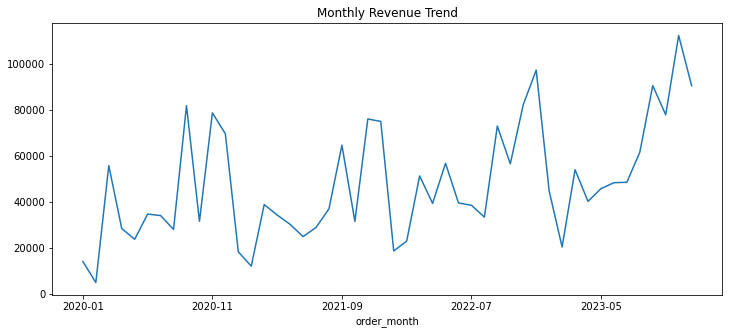

In [4]:
df['order_date'] = pd.to_datetime(df['order_date'], errors = 'coerce')
df['order_month'] = df['order_date'].dt.to_period('M').astype(str)
df = df.dropna(subset=['order_date'])
monthly_revenue = df.groupby('order_month')['sales'].sum()

monthly_revenue.plot(title='Monthly Revenue Trend', figsize=(12,5))

### DISCOUNT VS PROFIT

Text(0.5, 1.0, 'Discount vs Profit')

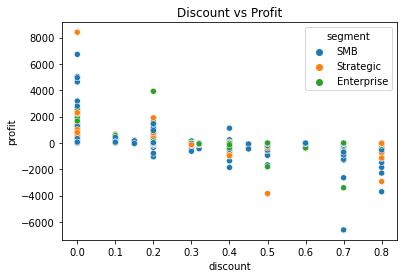

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='discount', y='profit', hue='segment')
plt.title('Discount vs Profit')

### HIGHEST PROFIT MARGIN PRODUCTS

In [6]:
df['profit_margin'] = df['profit'] / df['sales']
product_margin = df.groupby('product')[['profit_margin']].mean().sort_values('profit_margin', ascending=False)
product_margin.head(10)


,profit_margin
product,
SaaS Connector Pack - Gold,0.423140
Support,0.387410
Alchemy,0.317194
Storage,0.299171
ChatBot Plugin,0.251646
Data Smasher,0.218210
FinanceHub,0.187037
SaaS Connector Pack,0.137066
Site Analytics,0.119222


Feature	Description
profit_margin	profit / sales
discount_rate	Directly from column
is_high_discount	discount > 0.2 flag
order_month	for monthly revenue trend
product_revenue	total sales per product
segment_profitability	profit per segment


### DATABASE IMPLEMENTATION


In [7]:
import os

# Make sure the `db` folder exists
os.makedirs("/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/db", exist_ok=True)
import sqlite3

conn = sqlite3.connect("/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/db/saas_sales.db")
df.to_sql('sales_data', conn, if_exists='replace', index=False)


9994

### FORECASTING VALUES AND FINDING CORRELATIONS

#### Forecasting Revenue

In [8]:
df['order_month'] = df['order_date'].dt.to_period('M')
monthly_revenue = (
    df.groupby('order_month')['sales']
    .sum()
    .to_timestamp()
    .reset_index()
)
monthly_revenue.columns = ['ds', 'y']

16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing


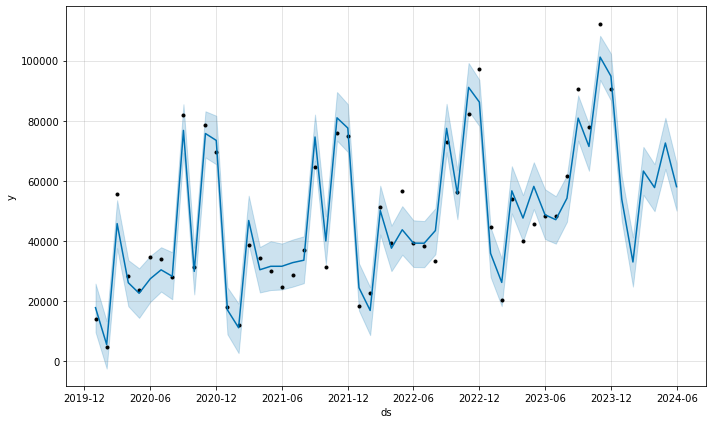

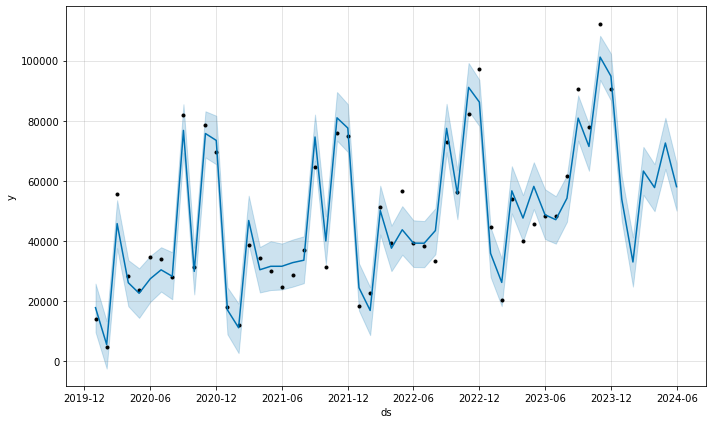

In [9]:
## forecasting revenues
from prophet import Prophet

model = Prophet()
model.fit(monthly_revenue)

future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

model.plot(forecast)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05020D+00    |proj g|=  5.55570D-01

At iterate    5    f=  7.89496D+00    |proj g|=  3.39717D-02

At iterate   10    f=  7.88210D+00    |proj g|=  2.94299D-02

At iterate   15    f=  7.87428D+00    |proj g|=  8.18801D-03

At iterate   20    f=  7.87416D+00    |proj g|=  1.63000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.238D-05   7.874D+00
  F =   7.8741615633740389     

CONVERG

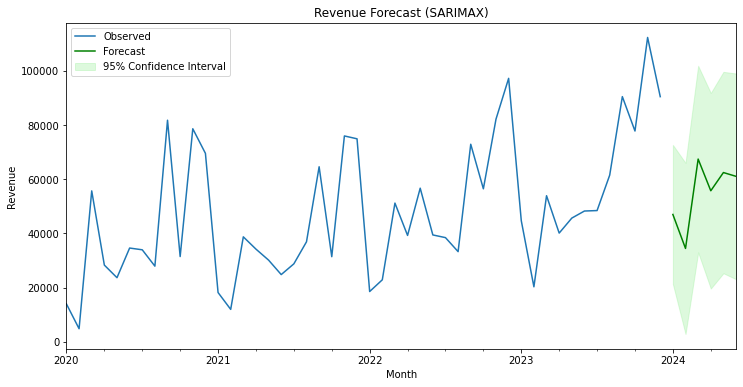

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

series = monthly_revenue.set_index('ds')['y']
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

forecast_object = results.get_forecast(steps=6)
forecast_mean = forecast_object.predicted_mean  
forecast_ci = forecast_object.conf_int()

forecast_df = pd.DataFrame({
    'ds': forecast_mean.index,
    'yhat': forecast_mean.values,
    'yhat_lower': forecast_ci.iloc[:, 0].values,
    'yhat_upper': forecast_ci.iloc[:, 1].values
})

import matplotlib.pyplot as plt

# Plot original series
series.plot(label='Observed', figsize=(12, 6))

# Forecast index (future months)
forecast_index = forecast_mean.index

# Plot forecast
forecast_mean.plot(label='Forecast', color='green')

# Plot confidence interval
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightgreen',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title("Revenue Forecast (SARIMAX)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.show()


#### PRICING ANALYTICS AND ELASTICITY RELATION

In [11]:
## pricing analytics
df['unit_price'] = df['sales'] / df['quantity']

price_demand = (
    df.groupby(['product', 'unit_price'])
    .agg(total_quantity=('quantity', 'sum'))
    .reset_index()
)

import numpy as np
from sklearn.linear_model import LinearRegression

price_demand = price_demand[price_demand['unit_price'] > 0]
price_demand['log_price'] = np.log(price_demand['unit_price'])
price_demand['log_qty'] = np.log(price_demand['total_quantity'])

model = LinearRegression()
model.fit(price_demand[['log_price']], price_demand['log_qty'])

elasticity = model.coef_[0]
print(f"Price Elasticity of Demand ≈ {elasticity:.2f}")

## Elasticity < -1: Elastic (lower price = more demand)
## Elasticity > -1: Inelastic (demand not very sensitive)

Price Elasticity of Demand ≈ -0.04


#### DISCOUNT IMPACT

<AxesSubplot:xlabel='discount_bin', ylabel='avg_profit'>

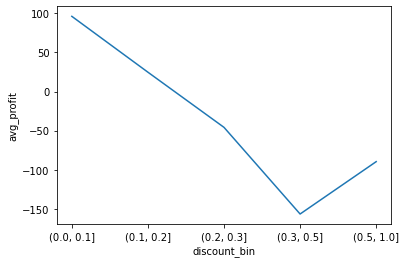

In [13]:
## Discount Impact Analysis (Profit vs Discount)
df['discount'] = pd.to_numeric(df['discount'], errors='coerce')
df = df.dropna(subset=['discount'])

df['discount_bin'] = pd.cut(df['discount'], bins=[0, 0.1, 0.2, 0.3, 0.5, 1.0])

discount_effect = df.groupby('discount_bin').agg(
    avg_sales=('sales', 'mean'),
    avg_profit=('profit', 'mean'),
    count=('sales', 'count')
).reset_index()
'''
import seaborn as sns
sns.lineplot(data=discount_effect, x='discount_bin', y='avg_profit')'''

discount_effect['discount_bin'] = discount_effect['discount_bin'].astype(str)
import seaborn as sns
sns.lineplot(data=discount_effect, x='discount_bin', y='avg_profit')

#### PRICE RESPONSE MODEL

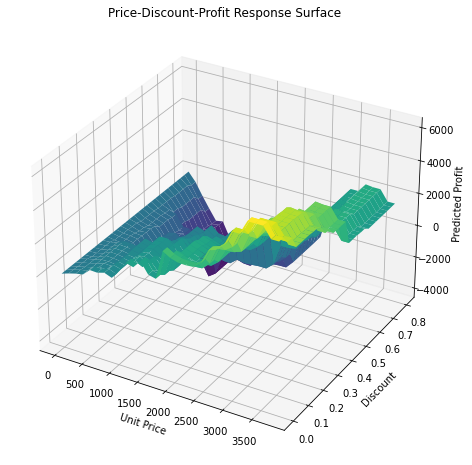

In [14]:

from sklearn.ensemble import RandomForestRegressor

features = df[['unit_price', 'discount', 'quantity']]
target = df['profit']

model = RandomForestRegressor()
model.fit(features, target)

# simulate a 10% price increase
sim_df = df.copy()
sim_df['unit_price'] *= 1.1
sim_df['predicted_profit'] = model.predict(sim_df[['unit_price', 'discount', 'quantity']])

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid of price and discount
price_range = np.linspace(df['unit_price'].min(), df['unit_price'].max(), 30)
discount_range = np.linspace(df['discount'].min(), df['discount'].max(), 30)
price_grid, discount_grid = np.meshgrid(price_range, discount_range)

# Predict profit using the model
test_grid = pd.DataFrame({
    'unit_price': price_grid.ravel(),
    'discount': discount_grid.ravel(),
    'quantity': df['quantity'].mean()  # assume constant quantity
})
predicted_profit = model.predict(test_grid).reshape(price_grid.shape)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(price_grid, discount_grid, predicted_profit, cmap='viridis')

ax.set_xlabel('Unit Price')
ax.set_ylabel('Discount')
ax.set_zlabel('Predicted Profit')
plt.title("Price-Discount-Profit Response Surface")
plt.show()



#### SEGMENTED PRICING STRATEGY

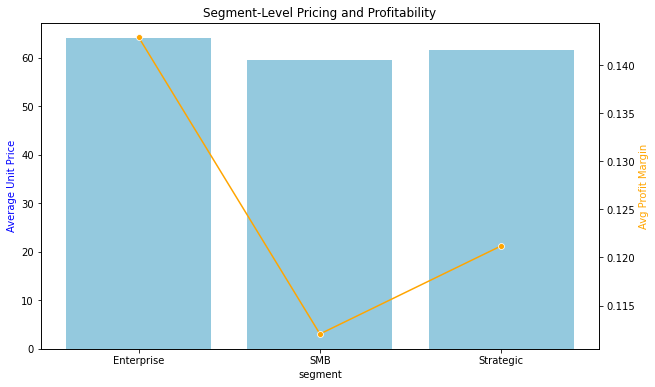

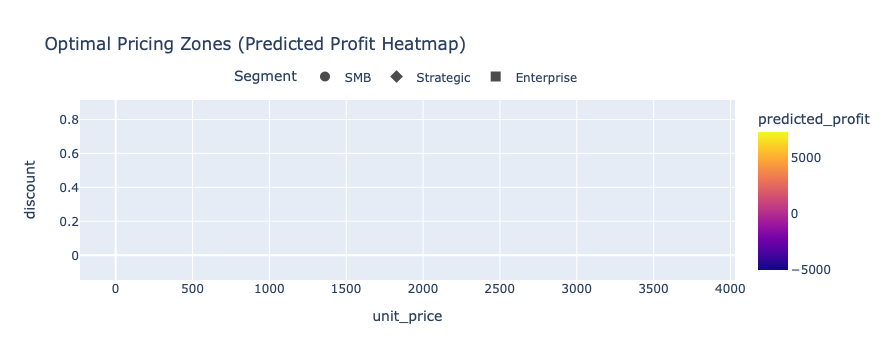

In [34]:

segment_prices = (
    df.groupby('segment')
    .agg(avg_unit_price=('unit_price', 'mean'),
         avg_profit_margin=('profit_margin', 'mean'))
    .reset_index()
)

segment_stats = df.groupby('segment').agg(
    avg_unit_price=('unit_price', 'mean'),
    avg_profit_margin=('profit_margin', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=segment_stats, x='segment', y='avg_unit_price', ax=ax1, color='skyblue')
ax1.set_ylabel("Average Unit Price", color='blue')

# Add secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=segment_stats, x='segment', y='avg_profit_margin', ax=ax2, color='orange', marker="o")
ax2.set_ylabel("Avg Profit Margin", color='orange')

plt.title("Segment-Level Pricing and Profitability")
plt.show()

sim_df['predicted_profit'] = model.predict(sim_df[['unit_price', 'discount', 'quantity']])

import plotly.express as px

fig = px.scatter(
    sim_df,
    x='unit_price',
    y='discount',
    color='predicted_profit',
    size=sim_df['predicted_profit'].abs(), 
    symbol='segment',
    hover_data=['segment'],
    title="Optimal Pricing Zones (Predicted Profit Heatmap)"
)

fig.update_layout(
    legend=dict(
        title='Segment',
        orientation='h',
        yanchor='bottom',
        y=1.05,
        xanchor='center',
        x=0.5
    )
)
fig.show()



### SAVING TO DATABASE

In [31]:
dfb = pd.read_csv('/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/data/raw/aws_saas_sales.csv')
print(dfb.columns)
if 'order_month' in dfb.columns:
    dfb.drop(columns=['order_month'], inplace=True)
dfb['order_date'] = pd.to_datetime(dfb['Order Date'], errors='coerce')
dfb['order_month'] = dfb['order_date'].dt.to_period('M').astype(str)

dfb.to_csv('/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/data/processed/cleaned_sales_data.csv', index=False)

# Save simulated revenue
df_sim = dfb.copy()
df_sim['simulated_sales'] = df_sim.apply(
    lambda row: row['Sales'] * 1.10 if row['Discount'] < 0.10 else row['Sales'],
    axis=1
)
df_sim[['order_date', 'Sales', 'simulated_sales', 'Profit', 'Segment', 'Region', 'Discount']].to_csv(
    '/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/data/processed/simulated_sales.csv', index=False)

# Save monthly revenue forecast
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(
    '/Users/anujkandwal/Desktop/Saas Pricing Analytics and Revenue Simulation/data/processed/forecast_monthly_revenue.csv', index=False)

Index(['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name',
       'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID',
       'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity',
       'Discount', 'Profit'],
      dtype='object')
